### Урок 2. Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

#### Домашнее задание
Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

Повторить п.2, но используя уже не медиану, а max
(опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

Рассматривать мы все будем в контексте решения конкретной прикладной задачи - задачи оттока

профилирование аудитории новостного портала


Представим, что мы - компания-агрегатор новостей (новостной портал).

У нас есть:

1. читатели
2. новости

Для каждого пользователя мы можем за какой-то период (например, 1 день) достать из базы данных список прочитанных им новостей.

Для каждой новости мы можем вытащить текст и метаинформацию.

### Задача #1: нужно построить модель прогнозирования оттока - это наша downstream-задача. 

Нам нужны:

1. векторное представление пользователя
2. сегменты, описывающие интересы пользователя

p.s. в контексте нашей задачи - это одно и то же

### С чего начнем?

С векторного представления и сегментов новостей!

Есть два очевидных варианта как это сделать:

1. многоклассовая классификация
2. кластеризация документов с последующей попыткой их (кластера) интерпретировать

Проблема:

1. для классификации нам нужно сначала разметить новости - привлечение ручного труда

### Задача тематического моделирования

#### Неформально!

- на свете бывают темы (заранее неизвестные), которые отражают то, о чём могут быть части документа;
- каждая тема – это распределение вероятностей на словах, т.е. мешок слов, из которого можно с разной вероятностью вытащить разные слова;
- каждый документ – это смесь тем, т.е. распределение вероятностей на темах, кубик, который можно кинуть;
- процесс порождения каждого слова состоит в том, чтобы сначала выбрать тему по распределению, соответствующему документу, а затем выбрать слово из распределения, соответствующего этой теме.

Вероятностные модели удобно понимать и представлять в виде порождающих процессов (generative processes), когда мы последовательно описываем, как порождается одна единица данных, вводя по ходу дела все вероятностные предположения, которые мы в этой модели делаем. Соответственно, порождающий процесс для LDA должен последовательно описывать, как мы порождаем каждое слово каждого документа. И вот как это происходит (здесь и далее я буду предполагать, что длина каждого документа задана – её тоже можно добавить в модель, но обычно это ничего нового не даёт):

1. для каждой темы t выбираем вектор phi_t - распределение слов в теме

2. для каждого документа d:

    2.1 выбираем Theta_d - распределение тем в документе
    
    2.2 для каждого из слов документа w:
        2.2.1 выбираем тему z~Theta_d
        2.2.2 выбираем слово w~p(w|z, phi)

#### Чуть более формально

Терминология:

1. документ - коллекция слов 
2. тема - набор токенов (слов), совместно часто встречающихся в документах

Более формально:

1. тема - условное распределение на множестве терминов, p(w|t)
2. тематический профиль документа - условное распределение тем p(t|d)

Вопрос: что же нам дано (в терминах условной вероятности)?

Ответ: условное распределение слов в документах - p(w|d)

Прекрасное объяснение от Воронцова - http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf

Тематическая модель позволяет нам получить p(w|t), p(t|d) по известным p(w|d)

### Переходим к практике

In [1]:
import pandas as pd
import re
import numpy as np
from nltk.corpus import stopwords

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import datapath
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

import itertools

import matplotlib.pyplot as plt
%matplotlib inline

# загрузка стопслов
# import nltk
# nltk.download('stopwords')

/Users/vladimir/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)

Bad key savefig.frameon in file /Users/vladimir/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/vladimir/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, 

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
print(len(stopword_ru))

151
777


In [5]:
morph = pymorphy2.MorphAnalyzer()

def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [6]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/Users/vladimir/opt/anaconda3/envs/DataScience/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Possible nested set at position 39


CPU times: user 22.8 s, sys: 246 ms, total: 23 s
Wall time: 23.6 s


In [7]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 3min 2s, sys: 1.05 s, total: 3min 3s
Wall time: 3min 6s


А теперь в 3 строчки обучим нашу модель

In [8]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [9]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

common_dictionary - это словарь наших слов

In [10]:
common_dictionary[10]

'взаимодействие'

common_corpus - это корпус Bag of Words (число вхождений каждого слова; результат возвращается в виде разреженного вектора)

In [11]:
common_corpus[:1]

[[(0, 2),
  (1, 1),
  (2, 2),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 4),
  (16, 1),
  (17, 1),
  (18, 4),
  (19, 1),
  (20, 1),
  (21, 3),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 2),
  (29, 1),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 2),
  (45, 1),
  (46, 2),
  (47, 1),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 3),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 3),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 3),
  (71, 1),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 3),
  (89, 2),
  (90, 1)]]

Запускаем обучение

In [12]:
%%time
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 1min 9s, sys: 2.07 s, total: 1min 11s
Wall time: 27 s


In [13]:
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [14]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title']]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[0]
print(other_texts[0])
lda[unseen_doc]

['заместитель', 'председатель', 'правительство', 'рф', 'сергей', 'иванов', 'избрать', 'председатель', 'совет', 'пбк', 'цска', 'прессслужба', 'армеец', 'решение', 'единогласно', 'принять', 'первый', 'заседание', 'совет', 'клуб', 'основной', 'функция', 'орган', 'обсуждение', 'текущий', 'состояние', 'планирование', 'утверждение', 'стратегия', 'развитие', 'клуб', 'близкий', 'перспектива', 'состав', 'совет', 'войти', 'георгий', 'полтавченко', 'полномочный', 'центральный', 'федеральный', 'округ', 'алексей', 'седов', 'генералполковник', 'начальник', 'служба', 'защита', 'конституционный', 'строй', 'борьба', 'терроризм', 'фсб', 'рф', 'александр', 'новак', 'заместитель', 'министр', 'финансы', 'рф', 'вячеслав', 'полтавец', 'заместитель', 'генеральный', 'директор', 'руководитель', 'блок', 'взаимодействие', 'орган', 'власть', 'социальный', 'корпоративный', 'политика', 'гмк', 'норильский', 'никель', 'леонид', 'исакович', 'генеральный', 'директор', 'ооо', 'ук', 'спортивный', 'проект', 'ольга', 'плеша

[(0, 0.06770602), (9, 0.8946531), (12, 0.017512504), (15, 0.011634639)]

In [15]:
len(other_texts)

27000

In [16]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: сократиться определение рекорд кг сооружение концерн партнёрство
topic_1: дональд греция билет бесплатный отреагировать вина саммит
topic_2: ракета страдать кремль путин сенатор парламент песок
topic_3: украина россия глава российский москва украинский документ
topic_4: ребёнок обнаружить дом семья британский обращение след
topic_5: миссия земля рейс снизить рост достигать перевод
topic_6: рубль выплата размер депутат закон россия налог
topic_7: место конкурс сигнал тыс сайт автор мир
topic_8: млн доход составить доллар тыс стоимость производитель
topic_9: млрд банк проект рубль наука министерство средство
topic_10: взрыв космос лечение законодательство автор врач медицинский
topic_11: сша китай остров университет восток северный американский
topic_12: всё рынок эксперт новый решение российский россия
topic_13: сша американский погибнуть научный запуск проверка анализ
topic_14: всё риск очень первый земля большой хороший
topic_15: век больной налоговый мышь пенсия распоряжение

Очень неплохо - большинство тем вполне можно описать о чем они

In [17]:
def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [18]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head()

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.067708,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.011634,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
1,4896,0.204380,0.2844,0.000000,0.000000,0.000000,0.000000,0.000000,0.070094,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
2,4897,0.155886,0.0000,0.000000,0.000000,0.000000,0.072306,0.000000,0.143118,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.120535,0.0,0.082161
3,4898,0.056085,0.0000,0.000000,0.000000,0.037754,0.000000,0.000000,0.000000,0.0,...,0.000000,0.0,0.239737,0.0,0.0,0.047846,0.0,0.000000,0.0,0.000000
4,4899,0.039151,0.0000,0.044798,0.344482,0.000000,0.000000,0.172364,0.124271,0.0,...,0.030285,0.0,0.000000,0.0,0.0,0.000000,0.0,0.027940,0.0,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [19]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [20]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [21]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list, type='mean'):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    if type == 'mean':
        user_vector = np.mean(user_vector, 0)
    if type == 'median':
        user_vector = np.median(user_vector, 0)
    if type == 'max':
        user_vector = np.max(user_vector, 0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [22]:
_type = ['mean', 'median', 'max']
user_embeddings = {}
for t in _type:
    user_embeddings[t] = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, t), 1)])
    user_embeddings[t].columns = ['topic_{}'.format(i) for i in range(25)]
    user_embeddings[t]['uid'] = users['uid'].values
    user_embeddings[t] = user_embeddings[t][['uid']+['topic_{}'.format(i) for i in range(25)]]
    print(t)
    print(user_embeddings[t][['uid', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5']].head(3), '...')
    print('-'*20)

mean
       uid   topic_0   topic_1   topic_2   topic_3   topic_4   topic_5
0  u105138  0.007114  0.003732  0.012733  0.209529  0.000000  0.003575
1  u108690  0.000000  0.023984  0.000000  0.192369  0.027175  0.009321
2  u108339  0.000000  0.004649  0.028566  0.160421  0.050585  0.003566 ...
--------------------
median
       uid  topic_0   topic_1   topic_2   topic_3   topic_4  topic_5
0  u105138      0.0  0.000000  0.000000  0.200625  0.000000      0.0
1  u108690      0.0  0.016178  0.000000  0.202552  0.021601      0.0
2  u108339      0.0  0.000000  0.014625  0.155117  0.033427      0.0 ...
--------------------
max
       uid   topic_0   topic_1   topic_2   topic_3   topic_4   topic_5
0  u105138  0.042682  0.022394  0.076398  0.489120  0.000000  0.021449
1  u108690  0.000000  0.070732  0.000000  0.296933  0.073270  0.035372
2  u108339  0.000000  0.017497  0.073900  0.277568  0.189959  0.010723 ...
--------------------


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [23]:
user_embeddings['mean'].head()

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.007114,0.003732,0.012733,0.209529,0.000000,0.003575,0.072155,0.115151,0.007216,...,0.000000,0.031956,0.000000,0.009838,0.089210,0.049044,0.062300,0.003194,0.015041,0.000000
1,u108690,0.000000,0.023984,0.000000,0.192369,0.027175,0.009321,0.025677,0.021112,0.012241,...,0.005179,0.083633,0.030637,0.000000,0.034662,0.145895,0.019547,0.003576,0.032695,0.002678
2,u108339,0.000000,0.004649,0.028566,0.160421,0.050585,0.003566,0.026029,0.019083,0.009630,...,0.000000,0.073422,0.023570,0.000000,0.066183,0.163982,0.035994,0.013893,0.046608,0.003152
3,u101138,0.226551,0.000000,0.000000,0.014808,0.032495,0.006357,0.002603,0.043486,0.014266,...,0.017174,0.007160,0.000000,0.004415,0.016196,0.174394,0.016279,0.000000,0.004119,0.000000
4,u108248,0.000000,0.005044,0.006924,0.144912,0.084440,0.004462,0.027421,0.008094,0.006363,...,0.002281,0.134383,0.082591,0.000000,0.018037,0.064715,0.026306,0.025929,0.003955,0.000000


In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
target = pd.read_csv("users_churn.csv")
target.head()

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0
3,u103439,0
4,u104300,0


In [26]:
X = {}
for t in _type:
    X[t] = pd.merge(user_embeddings[t], target, 'left')
    X[t].head(3)

mean
Best Threshold=0.225513, F-Score=0.667, Precision=0.594, Recall=0.759
roc_auc_score 0.9394429908715622
Confusion matrix, without normalization
[[1628  127]
 [  60  185]]


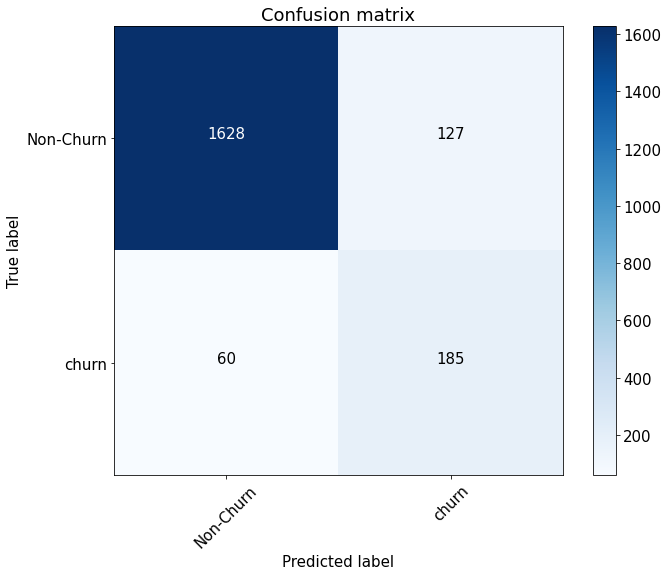

--------------------
median
Best Threshold=0.266575, F-Score=0.778, Precision=0.727, Recall=0.837
roc_auc_score 0.9730123844409558
Confusion matrix, without normalization
[[1678   77]
 [  41  204]]


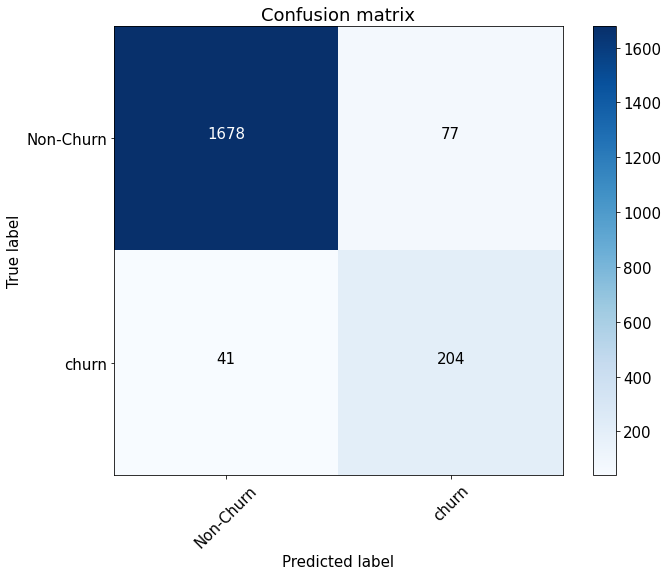

--------------------
max
Best Threshold=0.342205, F-Score=0.804, Precision=0.781, Recall=0.829
roc_auc_score 0.9770242455956741
Confusion matrix, without normalization
[[1698   57]
 [  43  202]]


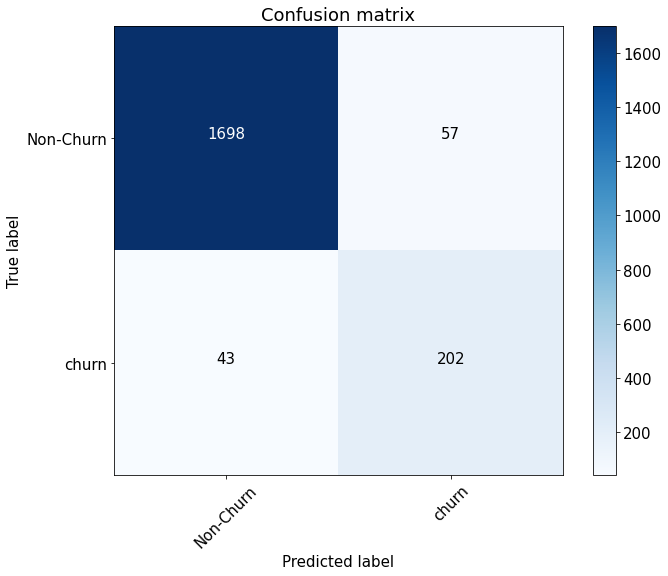

--------------------


In [27]:
_metrics = {}
for t in _type:
    print(t)
    #разделим данные на train/test
    X_train, X_test, y_train, y_test = train_test_split(X[t][['topic_{}'.format(i) for i in range(25)]],
                                                        X[t]['churn'], random_state=0)
    logreg = LogisticRegression()
    #обучим
    logreg.fit(X_train, y_train)
    #наши прогнозы для тестовой выборки
    preds = logreg.predict_proba(X_test)[:, 1]
    # print(preds[:10])

    precision, recall, thresholds = precision_recall_curve(y_test, preds)
    fscore = (2 * precision * recall) / (precision + recall)
    roc_auc = roc_auc_score(y_test, preds)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    _metrics[t] = [precision[ix], recall[ix], fscore[ix], roc_auc]
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
    print('roc_auc_score', roc_auc)

    #мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
    font = {'size' : 15}
    plt.rc('font', **font)
    cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'], title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()

    print('-'*20)

### Сформируем на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам  Precision, Recall, F_score и roc auc

In [28]:
metrics = pd.DataFrame.from_dict(_metrics, orient='index', columns=['precision', 'recall', 'fscore', 'roc_auc'])
metrics

,precision,recall,fscore,roc_auc
mean,0.594249,0.759184,0.666667,0.939443
median,0.726950,0.836735,0.777989,0.973012
max,0.780769,0.828571,0.803960,0.977024


В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу.